### Packages

In [ ]:
!pip install fredapi
from fredapi import Fred
fred_api = "9c6b8642b1610c723e2571ed42640b15"
fred = Fred(api_key=fred_api)
import copy
from datetime import datetime
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import random
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA

find right ARIMA orders for some time series of the dataset to apply syntetic augmentation of dataset

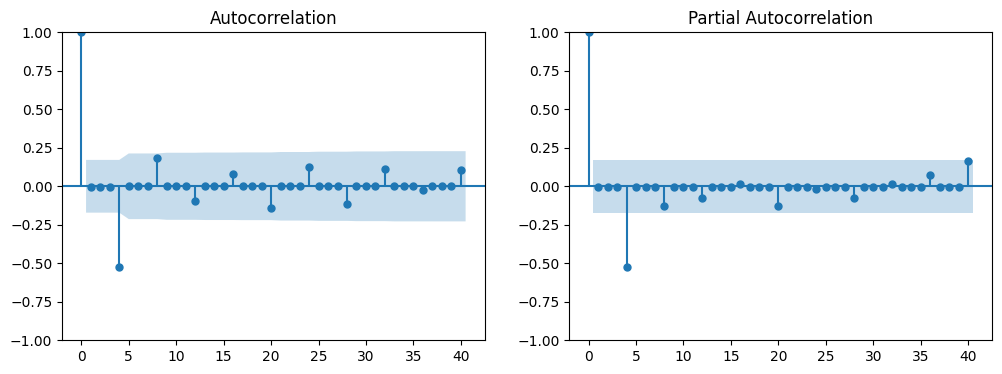

ARIMA Order for MHITX48113A052NCEN: (p=1, d=2, q=4)


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fredapi import Fred

# Initialize FRED API with your API key
fred = Fred(api_key='9c6b8642b1610c723e2571ed42640b15')

def fetch_and_process_series(series_id, frequency='QS'):
    """Fetch series from FRED and adjust frequency if necessary."""
    data = fred.get_series(series_id).dropna()
    data.index = pd.to_datetime(data.index)
    if frequency:
        data = data.resample(frequency).interpolate()
    return data

def test_stationarity(timeseries):
    """Perform Dickey-Fuller test to check stationarity of the series."""
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

def determine_diff_order(series):
    """Determine the differencing order required to make the series stationary."""
    d = 0
    result = test_stationarity(series)
    while result['p-value'] > 0.05:
        series = series.diff().dropna()
        result = test_stationarity(series)
        d += 1
    return series, d

def estimate_arima_order(series, max_lag=40):
    """Estimate ARIMA p and q orders based on ACF and PACF plots."""
    lag_acf = acf(series, nlags=max_lag)
    lag_pacf = pacf(series, nlags=max_lag, method='ols')
    p = sum(lag_pacf[1:] > 0.05) - 1
    q = sum(lag_acf[1:] > 0.05) - 1
    return p, q

def plot_acf_pacf(series, lags=40):
    """Plot ACF and PACF for the series."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series, ax=axes[0], lags=lags)
    plot_pacf(series, ax=axes[1], lags=lags)
    plt.show()

def analyze_series(series_id, frequency='QS', max_lag=40):
    """Comprehensive analysis of a time series including fetching, processing, and ARIMA order estimation."""
    data = fetch_and_process_series(series_id, frequency)
    diff_data, d = determine_diff_order(data)
    plot_acf_pacf(diff_data, lags=max_lag)
    p, q = estimate_arima_order(diff_data, max_lag)
    return (p, d, q)

# Example usage
series_id = "MHITX48113A052NCEN"  # Sample series ID for MHI data (annual frequency)
p, d, q = analyze_series(series_id)
print(f"ARIMA Order for {series_id}: (p={p}, d={d}, q={q})")


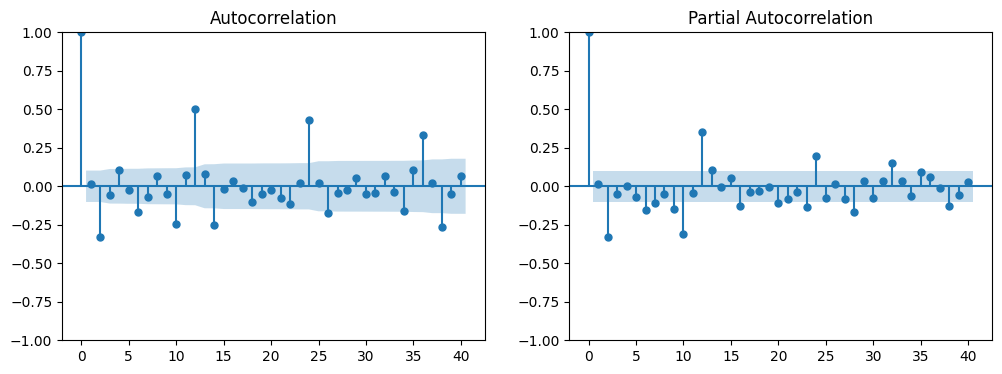

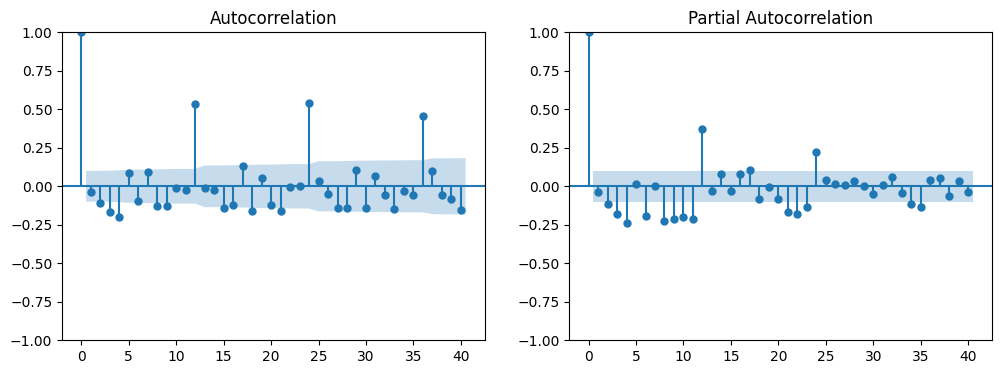

PCU721110721110103 ARIMA Order: (p=1, d=1, q=1)
MRTSSM44112USN ARIMA Order: (p=1, d=1, q=1)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fredapi import Fred

# Initialize FRED API with your API key
fred = Fred(api_key='9c6b8642b1610c723e2571ed42640b15')

def fetch_and_analyze_series(series_ids):
    """Fetch and analyze multiple time series from FRED."""

    results = {}

    for series_id in series_ids:
        # Fetch series data
        data = fred.get_series(series_id).dropna()
        data.index = pd.to_datetime(data.index)

        # Test for stationarity and determine differencing order
        d = 0
        result = adfuller(data, autolag='AIC')
        while result[1] > 0.05:
            data = data.diff().dropna()
            result = adfuller(data, autolag='AIC')
            d += 1

        # Plot ACF and PACF
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        plot_acf(data, ax=axes[0], lags=40)
        plot_pacf(data, ax=axes[1], lags=40)
        plt.show()

        # Estimate ARIMA orders
        acf_lags = acf(data, nlags=40)
        pacf_lags = pacf(data, nlags=40)
        p = next((i for i, x in enumerate(pacf_lags) if x < 0.05), len(pacf_lags)-1)
        q = next((i for i, x in enumerate(acf_lags) if x < 0.05), len(acf_lags)-1)

        results[series_id] = {'p': p, 'd': d, 'q': q}

    return results

# Example usage
series_ids = ["PCU721110721110103", "MRTSSM44112USN"] #monthly frequency
results = fetch_and_analyze_series(series_ids)
for key, value in results.items():
    print(f"{key} ARIMA Order: (p={value['p']}, d={value['d']}, q={value['q']})")


Function to augment time series

In [ ]:
import pandas as pd
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA

def augment_series(api_key, series_id, start_year, backcast_start_year, arima_order, frequency, col_name):
    """
    Augments a time series by backcasting data for missing years using an ARIMA model and resampling data based on its frequency.

    Parameters:
        api_key (str): The FRED API key.
        series_id (str): The FRED series ID.
        start_year (int): The first year for which the series has data.
        backcast_start_year (int): The starting year for backcasting.
        arima_order (tuple): The order (p, d, q) of the ARIMA model.
        frequency (str): The original frequency of the data ('annual', 'quarterly').

    Returns:
        pandas.DataFrame: A DataFrame containing the original and backcasted data.
    """
    # Initialize the FRED API
    fred = Fred(api_key=api_key)

    # Fetch the data from the specified start year onwards
    observation_start = f"{start_year}-01-01"
    data = fred.get_series(series_id, observation_start=observation_start)
    data = pd.DataFrame(data, columns=[col_name])
    data.index.name = 'Date'

    # Resample the data to monthly frequency based on its original reporting frequency
    if frequency == 'annual':
        data = data.resample('AS').last().interpolate(method='linear')
    elif frequency == 'quarterly':
        data = data.resample('QS').last().interpolate(method='linear')

    data = data.resample('MS').interpolate(method='linear')  # Ensuring all data is monthly

    # Fit an ARIMA model with the specified order
    model = ARIMA(data[col_name], order=arima_order)
    model_fit = model.fit()

    # Generate backcast for missing years
    backcast_length = 12 * (start_year - backcast_start_year)
    backcast = model_fit.predict(start=-backcast_length, end=-1, typ='levels')

    # Combine the original and backcasted data
    backcast.index = pd.date_range(start=f"{backcast_start_year}-01-01", periods=backcast_length, freq='M')
    augmented_data = pd.concat([backcast, data[col_name]])
    augmented_data = pd.DataFrame(augmented_data, columns=[col_name])
    augmented_data.index = augmented_data.index.to_period('M').to_timestamp()
    augmented_data.index.name = 'Date'

    return augmented_data

# Example usage:
api_key = '9c6b8642b1610c723e2571ed42640b15'  # Replace with your actual FRED API key
#series_id = "MHITX48113A052NCEN"  # Some series ID, adjust as needed
#arima_order = (1, 2, 4)  # ARIMA model order (p, d, q)
#frequency = 'annual'  # or 'quarterly'
#mhi = augment_series(api_key, series_id, 1989, 1976, arima_order, frequency)

#USED AUTO INDEX
series_id = "MRTSSM44112USN"  # Some series ID, adjust as needed
arima_order = (1, 1, 1)  # ARIMA model order (p, d, q)
frequency = 'monthly'  # or 'quarterly'
usedauto = augment_series(api_key, series_id, 1992, 1976, arima_order, frequency, "usedauto")
# Print the combined data
print(usedauto)

#LUXURY INDEX
series_id = "PCU721110721110103"  # Some series ID, adjust as needed
arima_order = (1, 1, 1)  # ARIMA model order (p, d, q)
frequency = 'monthly'  # or 'quarterly'
luxury = augment_series(api_key, series_id, 1993, 1976, arima_order, frequency, "luxury")
# Print the combined data
print(luxury)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                usedauto
Date                    
1976-01-01   7108.500151
1976-02-01   6860.794278
1976-03-01   6673.379349
1976-04-01   6651.543767
1976-05-01   6371.507455
...                  ...
2023-11-01  12016.000000
2023-12-01  11210.000000
2024-01-01  11862.000000
2024-02-01  13516.000000
2024-03-01  14299.000000

[579 rows x 1 columns]
                luxury
Date                  
1976-01-01  192.530007
1976-02-01  198.670851
1976-03-01  191.860060
1976-04-01  193.270529
1976-05-01  194.459296
...                ...
2023-12-01  268.617000
2024-01-01  304.188000
2024-02-01  296.925000
2024-03-01  309.863000
2024-04-01  292.691000

[575 rows x 1 columns]


Get regimes augmented time series

In [ ]:
import pandas as pd
import numpy as np

def load_economic_regimes(file_path):
    # Load the CSV file using pandas
    reg = pd.read_csv(file_path)
    reg = reg.iloc[:, [0, -1]]  # Select only the first (date) and last (regimes) columns
    reg.columns = ['Date', 'Regimes']  # Rename columns for clarity
    reg['Date'] = pd.to_datetime(reg['Date'])
    reg['Date'] = reg['Date'].dt.to_period('M').dt.to_timestamp()

    reg.set_index('Date', inplace=True)
    print(reg.head())
    return reg

reg = load_economic_regimes("/content/elisa_5_regimes.csv")
data = reg
df = pd.DataFrame(data)
df['Regimes'] = df['Regimes'].astype(float)

# Determine unique states

# Determine unique states and initialize transition matrix
states = df['Regimes'].unique()
states.sort()
transition_matrix = pd.DataFrame(0, index=states, columns=states)

# Count transitions
for (prev, curr) in zip(df['Regimes'].shift(1), df['Regimes']):
    if pd.notna(prev) and pd.notna(curr):
        transition_matrix.loc[prev, curr] += 1

# Apply Laplace Smoothing by adding 1 to avoid zeros
transition_matrix += 1

# Normalize the matrix to ensure probabilities sum to 1
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).values

print(transition_matrix)


            Regimes
Date               
1990-01-01      1.0
1990-02-01      1.0
1990-03-01      1.0
1990-04-01      1.0
1990-05-01      1.0
[[0.78082192 0.05479452 0.04109589 0.05479452 0.06849315]
 [0.0952381  0.76190476 0.04761905 0.06349206 0.03174603]
 [0.01775148 0.02366864 0.92307692 0.01183432 0.02366864]
 [0.06666667 0.11111111 0.04444444 0.71111111 0.06666667]
 [0.05       0.025      0.0625     0.0375     0.825     ]]


In [ ]:
states = [1.0, 2.0, 3.0, 4.0, 5.0]  # Explicit state values
transition_matrix = np.array([
    [0.78082192, 0.05479452, 0.04109589, 0.05479452, 0.06849315],  # Probabilities from state 1
    [0.0952381,  0.76190476, 0.04761905, 0.06349206, 0.03174603],  # Probabilities from state 2
    [0.01775148, 0.02366864, 0.92307692, 0.01183432, 0.02366864],  # Probabilities from state 3
    [0.06666667, 0.11111111, 0.04444444, 0.71111111, 0.06666667],  # Probabilities from state 4
    [0.05,       0.025,      0.0625,     0.0375,     0.825]   # Probabilities from state 5
])

def simulate_markov_chain(transitions, n_steps, start_state_value):
    # Get the index of the start state from the state list
    current_index = states.index(start_state_value)  # Map state value to index
    state_sequence = [start_state_value]  # Start with the initial state value

    for _ in range(n_steps):
        # Choose the next state index based on the transition probabilities of the current state
        next_index = np.random.choice(len(states), p=transitions[current_index])
        # Append the state value corresponding to the chosen index
        state_sequence.append(states[next_index])
        # Update the current index for the next iteration
        current_index = next_index

    return state_sequence

# Initialize parameters for the simulation
start_state = 1.0  # Starting state value
n_steps = (1990 - 1976) * 12  # Number of months from January 1976 to the start of 1990

# Simulate the Markov chain to backcast states
simulated_states = simulate_markov_chain(transition_matrix, n_steps, start_state)

# Generate the corresponding date range for the backcast
backcast_dates = pd.date_range(start='1976-01-01', periods=n_steps+1, freq='M')

# Create a DataFrame to store the backcasted states with their dates
backcast_df = pd.DataFrame({'Regimes': simulated_states}, index=backcast_dates)
backcast_df.index = backcast_df.index.to_period('M').to_timestamp()
backcast_df.index.name = 'Date'
# Output the beginning of the DataFrame to verify the results
print(backcast_df.head())


            Regimes
Date               
1976-01-01      1.0
1976-02-01      1.0
1976-03-01      1.0
1976-04-01      1.0
1976-05-01      5.0


In [ ]:
import pandas as pd

# Assuming 'reg' is your DataFrame from 1990 onwards, already loaded and processed
# And 'backcast_df' is your DataFrame from 1976 to 1989, as created in your simulation

# Check if there is any overlap or gap at the junction point
if backcast_df.index[-1] >= reg.index[0]:
    print("Overlap in dates detected! Adjusting...")
    reg = reg[reg.index > backcast_df.index[-1]]

# Concatenate the two DataFrames to form a continuous time series
combined_df = pd.concat([backcast_df, reg])
regimes = combined_df
# Optionally, check the transition between the two DataFrames around the junction point to ensure continuity
print(regimes.loc[regimes.index.isin([backcast_df.index[-1], reg.index[0]])])

# Display the head and tail of the combined DataFrame to verify the integration
print(regimes.head())
print(regimes.tail())


Overlap in dates detected! Adjusting...
            Regimes
Date               
1990-01-01      3.0
1990-02-01      1.0
            Regimes
Date               
1976-01-01      1.0
1976-02-01      1.0
1976-03-01      1.0
1976-04-01      1.0
1976-05-01      5.0
            Regimes
Date               
2023-06-01      5.0
2023-07-01      5.0
2023-08-01      1.0
2023-09-01      1.0
2023-10-01      1.0


In [ ]:
class national_ms():
    def __init__(self):
        self.fred_key_mortgage_rate = "MORTGAGE30US"
        self.fred_key_credit = "BOGZ1FA673065500Q"
        self.fred_key_CPI = "CPIAUCSL"
        self.fred_key_GDP = "GDP"
        self.fred_key_treasury = "T10Y2Y"
        self.fred_key_debt = "GFDEBTN"
        self.fred_key_unemployment = "UNRATE"
        self.fred_key_bci = "BSCICP03USM665S"
        self.fred_key_retailauto = "DAUTOSAAR" #Motor Vehicle Retail Sales: Domestic Autos


        self.alpha = 0.17 # proportion of gross income a household can allocate to mortgage repayments
        self.beta = 0.2 # downpayment ratio
        self.N = 30
        self.gdp = self.get_gdp()
        self.cpi = self.get_cpi()
        self.treasury = self.get_treasury()
        self.credit = self.get_credit()
        self.mortgage_rate = self.get_mortgage()
        self.debt = self.get_debt()
        self.unemployment = self.get_unemployment()
        self.bci = self.get_bci()
        self.retailauto= self.get_retail()
        self.usedauto = usedauto
        self.luxury = luxury
        self.economic_regimes = regimes
        #backtest

    def get_mortgage(self):
        # original weekly
        mortgage_rate = fred.get_series("MORTGAGE30US").dropna()
        mortgage_rate = pd.DataFrame(mortgage_rate, columns=["Mortgage_Rate"])
        # Set the date column as the index
        mortgage_rate.index.name = 'Date'
        # Resample to monthly, taking the last value of each month, and interpolate missing data if any
        mortgage_rate = mortgage_rate.resample('MS').last().interpolate()
        # Reset the index so that Date is a column
        mortgage_rate.reset_index(inplace=True)
        # Affordable limit (AL)
        mortgage_rate['AL'] = (self.alpha / (1-self.beta)) * ((1-np.power(1+mortgage_rate['Mortgage_Rate']/(100), -self.N))/(mortgage_rate['Mortgage_Rate']/(100)))
        mortgage_rate['AL_monthly'] = (self.alpha / (1-self.beta)) * ((1-np.power(1+mortgage_rate['Mortgage_Rate']/(12*100), -self.N*12))/(mortgage_rate['Mortgage_Rate']/(12*100)))
        return mortgage_rate

    def get_gdp(self):
        # original quarterly
        gdp = fred.get_series('GDP').dropna()
        gdp = pd.DataFrame(gdp, columns=["GDP"])
        gdp.index.name = 'Date'
        gdp = gdp.resample('MS').interpolate()
        gdp.reset_index(inplace=True)
        return gdp

    def get_cpi(self):
        # original monthly
        cpi = fred.get_series("CPIAUCSL").dropna()
        cpi = pd.DataFrame(cpi, columns=['CPI'])
        cpi.index.name = 'Date'
        cpi.reset_index(inplace=True)
        return cpi





    def get_used(self):
        # original monthly
        usedauto = fred.get_series("MRTSSM44112USN").dropna()
        usedauto = pd.DataFrame(usedauto, columns=['usedauto'])
        usedauto.index.name = 'Date'
        usedauto.reset_index(inplace=True)

        return usedauto

    def get_retail(self):
        # original monthly
        retailauto = fred.get_series("DAUTOSAAR").dropna()
        retailauto = pd.DataFrame(retailauto, columns=['retailauto'])
        retailauto.index.name = 'Date'
        retailauto.reset_index(inplace=True)
        return retailauto

    def get_treasury(self):
        # original daily
        treasury = fred.get_series(self.fred_key_treasury).dropna()
        treasury = pd.DataFrame(treasury, columns=["Treasury"])
        treasury.index.name = 'Date'
        treasury = treasury.resample('MS').last().interpolate()
        treasury.reset_index(inplace=True)
        return treasury

    def get_credit(self):
        # original quarterly
        credit = fred.get_series('BOGZ1FA673065500Q').dropna()
        credit = pd.DataFrame(credit, columns=["Credit_Availability"])
        credit.index.name = 'Date'
        credit = credit.resample('MS').interpolate()
        credit.reset_index(inplace=True)
        return credit

    def get_debt(self):
        # original quaterly
        debt = fred.get_series(self.fred_key_debt).dropna()
        debt = pd.DataFrame(debt, columns=["Corp_debt"])
        debt.index.name = 'Date'
        debt = debt.resample('MS').interpolate()
        debt.reset_index(inplace=True)
        return debt

    def get_unemployment(self):
        # original monthly
        unemployment = fred.get_series(self.fred_key_unemployment).dropna().reset_index(level=0)
        unemployment = unemployment.rename(columns={"index":"Date", 0:"unemployment"}).set_index('Date')
        unemployment = pd.DataFrame(unemployment)
        return unemployment

    def get_bci(self):
        bci = fred.get_series(self.fred_key_bci).dropna().reset_index(level=0)
        bci = bci.rename(columns={"index":"Date", 0:"BusinessConfidenceIndex"}).set_index('Date')
        bci = pd.DataFrame(bci)

        return bci





    def merge(self):
        # merge every national inputs together
        df = pd.merge(self.mortgage_rate, self.gdp, on='Date', how='left')
        df = pd.merge(df, self.cpi, on='Date', how='left')
        df = pd.merge(df, self.treasury, on='Date', how='left')
        df = pd.merge(df, self.credit, on='Date', how='left')
        df = pd.merge(df, self.debt, on='Date', how='left')
        df = pd.merge(df, self.unemployment, on='Date', how='left')
        df = pd.merge(df, self.bci, on='Date', how='left')
        df = pd.merge(df, self.economic_regimes, on='Date', how='left')
        df = pd.merge(df, self.usedauto, on='Date', how='left')
        df = pd.merge(df, self.retailauto, on='Date', how='left')
        df = pd.merge(df, self.luxury, on='Date', how='left')

        df = df.dropna()
        print(df)
        return df

In [ ]:
us = national_ms()

In [ ]:
us.merge()

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
62  1976-06-01           8.90  2.202657   26.647846   1875.149333   56.700   
63  1976-07-01           8.98  2.187029   26.457201   1886.558000   57.000   
64  1976-08-01           9.00  2.183151   26.409896   1902.463000   57.300   
65  1976-09-01           8.97  2.188972   26.480907   1918.368000   57.600   
66  1976-10-01           8.90  2.202657   26.647846   1934.273000   57.900   
..         ...            ...       ...         ...           ...      ...   
626 2023-06-01           6.71  2.715597   32.897719  27427.756000  304.003   
627 2023-07-01           6.81  2.688042   32.562487  27610.128000  304.628   
628 2023-08-01           7.18  2.589933   31.368331  27725.751333  306.187   
629 2023-09-01           7.31  2.556842   30.965363  27841.374667  307.288   
630 2023-10-01           7.79  2.440469   29.547608  27956.998000  307.531   

     Treasury  Credit_Availability     Corp_debt  unemployment 

,Date,Mortgage_Rate,AL,AL_monthly,GDP,CPI,Treasury,Credit_Availability,Corp_debt,unemployment,BusinessConfidenceIndex,Regimes,usedauto,retailauto,luxury
62,1976-06-01,8.90,2.202657,26.647846,1875.149333,56.700,0.84,0.000000,6.299447e+05,7.6,101.00330,5.0,6316.198257,8.430,196.555219
63,1976-07-01,8.98,2.187029,26.457201,1886.558000,57.000,1.12,0.000000,6.347010e+05,7.8,100.64430,5.0,5875.572671,8.549,199.011836
64,1976-08-01,9.00,2.183151,26.409896,1902.463000,57.300,1.16,0.000000,6.409817e+05,7.8,100.32090,5.0,5676.242843,7.990,197.769412
65,1976-09-01,8.97,2.188972,26.480907,1918.368000,57.600,1.22,0.000000,6.472623e+05,7.6,100.09800,5.0,4900.893494,8.452,208.573511
66,1976-10-01,8.90,2.202657,26.647846,1934.273000,57.900,1.39,0.000000,6.535430e+05,7.7,100.00210,5.0,4934.239112,7.710,209.403898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,2023-06-01,6.71,2.715597,32.897719,27427.756000,304.003,-1.06,3722.666667,3.288898e+07,3.6,98.53253,5.0,14595.000000,2.299,271.079000
627,2023-07-01,6.81,2.688042,32.562487,27610.128000,304.628,-0.91,20346.000000,3.316733e+07,3.5,98.59760,5.0,14191.000000,2.339,288.164000
628,2023-08-01,7.18,2.589933,31.368331,27725.751333,306.187,-0.76,2006.333333,3.344539e+07,3.8,98.70704,1.0,15415.000000,2.238,269.571000
629,2023-09-01,7.31,2.556842,30.965363,27841.374667,307.288,-0.44,-16333.333333,3.372344e+07,3.8,98.75687,1.0,13822.000000,2.315,257.465000


In [ ]:
df1 = us.merge()

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
62  1976-06-01           8.90  2.202657   26.647846   1875.149333   56.700   
63  1976-07-01           8.98  2.187029   26.457201   1886.558000   57.000   
64  1976-08-01           9.00  2.183151   26.409896   1902.463000   57.300   
65  1976-09-01           8.97  2.188972   26.480907   1918.368000   57.600   
66  1976-10-01           8.90  2.202657   26.647846   1934.273000   57.900   
..         ...            ...       ...         ...           ...      ...   
626 2023-06-01           6.71  2.715597   32.897719  27427.756000  304.003   
627 2023-07-01           6.81  2.688042   32.562487  27610.128000  304.628   
628 2023-08-01           7.18  2.589933   31.368331  27725.751333  306.187   
629 2023-09-01           7.31  2.556842   30.965363  27841.374667  307.288   
630 2023-10-01           7.79  2.440469   29.547608  27956.998000  307.531   

     Treasury  Credit_Availability     Corp_debt  unemployment 

In [ ]:
final_df = us.merge()

# Export the DataFrame to CSV
final_csv_path = 'national_data.csv'
final_df.to_csv(final_csv_path, index=False)

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
62  1976-06-01           8.90  2.202657   26.647846   1875.149333   56.700   
63  1976-07-01           8.98  2.187029   26.457201   1886.558000   57.000   
64  1976-08-01           9.00  2.183151   26.409896   1902.463000   57.300   
65  1976-09-01           8.97  2.188972   26.480907   1918.368000   57.600   
66  1976-10-01           8.90  2.202657   26.647846   1934.273000   57.900   
..         ...            ...       ...         ...           ...      ...   
626 2023-06-01           6.71  2.715597   32.897719  27427.756000  304.003   
627 2023-07-01           6.81  2.688042   32.562487  27610.128000  304.628   
628 2023-08-01           7.18  2.589933   31.368331  27725.751333  306.187   
629 2023-09-01           7.31  2.556842   30.965363  27841.374667  307.288   
630 2023-10-01           7.79  2.440469   29.547608  27956.998000  307.531   

     Treasury  Credit_Availability     Corp_debt  unemployment 

merge df

#### city
- hpi
- mhi interpolated
- building permits(single/multi) (need more data)

first, we need bb interpolation

In [ ]:
def brownian_bridge(x0, y0, x1, y1, std_month, interpolated, base_date, col_name):
    """
    Interpolate values between two data points in a time series using Brownian Bridge.
    """
    xm = (x0 + x1) / 2
    ym = np.random.normal(loc=(y0 + y1) / 2, scale=std_month)
    interpolated['Date'].append(pd.Timestamp(base_date).to_period('M') + int(xm))
    interpolated[col_name].append(ym)

    if (x1 - x0) > 1:
        brownian_bridge(x0, y0, xm, ym, std_month * np.sqrt((xm - x0) / (x1 - x0)), interpolated, base_date, col_name)
        brownian_bridge(xm, ym, x1, y1, std_month * np.sqrt((x1 - xm) / (x1 - x0)), interpolated, base_date, col_name)

def bb_interpolation(data, column, seed=2022):
    """
    Apply Brownian Bridge interpolation to time series data for a specific column.
    """
    temp_data = data.copy()
    # Add a MonthIndex column for internal calculations
    temp_data['MonthIndex'] = (temp_data.index.year - temp_data.index.min().year) * 12 + (temp_data.index.month - temp_data.index.min().month)
    std_all = np.std(temp_data[column].values)
    month_range = temp_data['MonthIndex'].max() - temp_data['MonthIndex'].min()
    std_month = std_all / np.sqrt(month_range)
    interpolated = {'Date': [], column: []}
    np.random.seed(seed)

    sorted_data = temp_data.sort_index()
    x = sorted_data['MonthIndex'].values
    y = sorted_data[column].values

    for i in range(len(temp_data) - 1):
        brownian_bridge(x[i], y[i], x[i + 1], y[i + 1], std_month, interpolated, temp_data.index.min(), column)

    interpolated_df = pd.DataFrame(interpolated)
    interpolated_df.set_index('Date', inplace=True)
    interpolated_df.index = interpolated_df.index.to_timestamp()

    # Filter out interpolated points that have dates already present in the original data
    new_points = interpolated_df[~interpolated_df.index.isin(data.index)]

    # Merge the new points into the original data and sort
    df_interpolated = pd.concat([data, new_points]).sort_index()

    return df_interpolated

define city_ms() to retrieve city level data

DATA AUGMENTATION FOR CITY LEVEL


In [ ]:
import pandas as pd
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA

def augment_series(api_key, series_id, start_year, backcast_start_year, arima_order, frequency, col_data):
    """
    Augments a time series by backcasting data for missing years using an ARIMA model and resampling data based on its frequency.

    Parameters:
        api_key (str): The FRED API key.
        series_id (str): The FRED series ID.
        start_year (int): The first year for which the series has data.
        backcast_start_year (int): The starting year for backcasting.
        arima_order (tuple): The order (p, d, q) of the ARIMA model.
        frequency (str): The original frequency of the data ('annual', 'quarterly').

    Returns:
        pandas.DataFrame: A DataFrame containing the original and backcasted data.
    """
    # Initialize the FRED API
    fred = Fred(api_key=api_key)

    # Fetch the data from the specified start year onwards
    observation_start = f"{start_year}-01-01"
    data = fred.get_series(series_id, observation_start=observation_start)
    data = pd.DataFrame(data, columns=[col_data])
    data.index.name = 'Date'

    # Resample the data to monthly frequency based on its original reporting frequency
    if frequency == 'annual':
        data = data.resample('AS').last().interpolate(method='linear')
    elif frequency == 'quarterly':
        data = data.resample('QS').last().interpolate(method='linear')

    data = data.resample('MS').interpolate(method='linear')  # Ensuring all data is monthly

    # Fit an ARIMA model with the specified order
    model = ARIMA(data[col_data], order=arima_order)
    model_fit = model.fit()

    # Generate backcast for missing years
    backcast_length = 12 * (start_year - backcast_start_year)
    backcast = model_fit.predict(start=-backcast_length, end=-1, typ='levels')

    # Combine the original and backcasted data
    backcast.index = pd.date_range(start=f"{backcast_start_year}-01-01", periods=backcast_length, freq='M')
    augmented_data = pd.concat([backcast, data[col_data]])
    augmented_data = pd.DataFrame(augmented_data, columns=[col_data])
    augmented_data.index = augmented_data.index.to_period('M').to_timestamp()
    augmented_data.index.name = 'Date'

    return augmented_data

# Example usage:
api_key = '9c6b8642b1610c723e2571ed42640b15'  # Replace with your actual FRED API key
series_id = "MHITX48113A052NCEN"  # Some series ID, adjust as needed
arima_order = (1, 2, 4)  # ARIMA model order (p, d, q)
frequency = 'annual'  # or 'quarterly'
mhi = augment_series(api_key, series_id, 1989, 1976, arima_order, frequency, "mhi")

# Print the combined data
print(mhi)


                     mhi
Date                    
1976-01-01  45961.865709
1976-02-01  46183.034717
1976-03-01  46264.618414
1976-04-01  46328.728924
1976-05-01  46401.281451
...                  ...
2021-09-01  68430.333333
2021-10-01  69040.500000
2021-11-01  69650.666667
2021-12-01  70260.833333
2022-01-01  70871.000000

[553 rows x 1 columns]


In [ ]:
#get augmented data for permits

def get_multi(link):
    url = link
    # Read the dataset and set 'Date' as the index, dropping the unnamed column
    building_permit = pd.read_csv(url, parse_dates=['Date'], index_col='Date').drop('Unnamed: 0',axis=1)
    # Keep only the data before 2023-09-01 to avoid zero values
    building_permit = building_permit.loc[building_permit.index < '2023-09-01']
    # Set the index to the first day of the month for alignment with other data
    building_permit.index = building_permit.index.to_period('M').to_timestamp()
    # Filter data for multi-family housing units and rename columns
    multi = building_permit[building_permit['Unit_Type'] == 'Units in 5+ Unit Multi-Family Structures'].drop(columns='Unit_Type')
    multi = multi.rename(columns={'Permits': 'MultiFamilyPermits'})
    print(multi)
    return multi

In [ ]:
def get_single(link):
        url = link
        # Read the grouped data file and assign date as index, drop the unnamed column
        building_permit = pd.read_csv(url, parse_dates=['Date'], index_col='Date').drop('Unnamed: 0',axis=1)
        # Keep only the data before 2023-09-01 to avoid zero values
        building_permit = building_permit.loc[building_permit.index < '2023-09-01']
        # Set the index to the month end for alignment with other datasets
        building_permit.index = building_permit.index.to_period('M').to_timestamp()

        # Filter data for single-family housing units and rename columns
        single = building_permit[building_permit['Unit_Type'] == 'Units in Single-Family Structures'].drop(columns='Unit_Type')
        single = single.rename(columns={'Permits': 'SingleFamilyPermits'})
        print(single)
        return single

In [ ]:
single = get_single("/content/Permits_Dallas.csv")

            SingleFamilyPermits
Date                           
2001-01-01                316.0
2001-02-01                408.0
2001-03-01                446.0
2001-04-01                387.0
2001-05-01                425.0
...                         ...
2023-04-01                245.0
2023-05-01                139.0
2023-06-01                139.0
2023-07-01                178.0
2023-08-01                245.0

[272 rows x 1 columns]


In [ ]:
multi = get_multi("/content/Permits_Dallas.csv")

            MultiFamilyPermits
Date                          
2001-01-01                 0.0
2001-02-01                54.0
2001-03-01              1210.0
2001-04-01               261.0
2001-05-01               435.0
...                        ...
2023-04-01               355.0
2023-05-01               525.0
2023-06-01                37.0
2023-07-01               374.0
2023-08-01               541.0

[272 rows x 1 columns]


In [ ]:
#data = multi["MultiFamilyPermits"]

In [ ]:

def predict_permits(link, type_permits, col_name, order):
    # Load the dataset from the given link
    building_permit = pd.read_csv(link, parse_dates=['Date'], index_col='Date')
    # Drop any unnamed columns
    if 'Unnamed: 0' in building_permit.columns:
        building_permit = building_permit.drop(columns='Unnamed: 0')
    # Filter data for multi-family housing units and rename columns
    permit = building_permit[building_permit['Unit_Type'] == type_permits].drop(columns='Unit_Type')
    permit = permit.rename(columns={'Permits': col_name})
    # Ensure the data is ordered by date
    permit = permit.sort_index()
    # Fit an ARIMA model;
    model = ARIMA(permit[col_name], order=order)
    model_fit = model.fit()
    # Determine how many months to backcast
    start_year = permit.index.min().year
    backcast_start_year = 1978  # or earlier, adjust as needed
    backcast_length = 12 * (start_year - backcast_start_year)
# Generate backcast for missing years

    if backcast_length > 0:
        backcast = model_fit.predict(start=-backcast_length, end=-1, typ='levels')
        backcast.index = pd.date_range(start=f'{backcast_start_year}-01-01', periods=backcast_length, freq='M')
        # Combine the original and backcasted data
        augmented_data = pd.concat([backcast, permit[col_name]])
        augmented_data = pd.DataFrame(augmented_data, columns=[col_name])

    else:
        augmented_data = permit
    # Reset the index to the first day of the month
    augmented_data.index = augmented_data.index.to_period('M').to_timestamp()
    augmented_data.index.name = 'Date'
    return augmented_data

Permits for each city

In [ ]:
#DALLAS SINGLE AND MULTI
link = "/content/Permits_Dallas.csv"  # Replace with your actual data link
permits_dallas_multi = predict_permits(link,"Units in 5+ Unit Multi-Family Structures" ,"MultiFamilyPermits", (1, 1, 1))
print(permits_dallas_multi)

permits_dallas_single = predict_permits(link,"Units in Single-Family Structures" ,"SingleFamilyPermits", (1, 1, 1))
print(permits_dallas_single)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            MultiFamilyPermits
Date                          
1978-01-01            0.000000
1978-02-01            0.000000
1978-03-01           28.578690
1978-04-01          509.733289
1978-05-01          352.885913
...                        ...
2023-08-01          541.000000
2023-09-01            0.000000
2023-10-01            0.000000
2023-11-01            0.000000
2023-12-01            0.000000

[552 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SingleFamilyPermits
Date                           
1978-01-01             0.000000
1978-02-01           315.411109
1978-03-01           374.624609
1978-04-01           406.062645
1978-05-01           386.764296
...                         ...
2023-08-01           245.000000
2023-09-01             0.000000
2023-10-01             0.000000
2023-11-01             0.000000
2023-12-01             0.000000

[552 rows x 1 columns]


In [ ]:
#MIAMI SINGLE AND MULTI
link = "/content/Permits_Miami.csv"  # Replace with your actual data link
permits_miami_multi = predict_permits(link,"Units in 5+ Unit Multi-Family Structures" ,"MultiFamilyPermits", (1, 1, 1))
print(permits_miami_multi)

permits_miami_single = predict_permits(link,"Units in Single-Family Structures" ,"SingleFamilyPermits", (1, 1, 1))
print(permits_miami_single)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            MultiFamilyPermits
Date                          
1978-01-01            0.000000
1978-02-01          709.454782
1978-03-01          446.630022
1978-04-01          323.420870
1978-05-01          317.302736
...                        ...
2023-08-01         1994.000000
2023-09-01            0.000000
2023-10-01            0.000000
2023-11-01            0.000000
2023-12-01            0.000000

[552 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SingleFamilyPermits
Date                           
1978-01-01             0.000000
1978-02-01           522.913426
1978-03-01           591.952273
1978-04-01           577.635016
1978-05-01           571.650633
...                         ...
2023-08-01            43.000000
2023-09-01             0.000000
2023-10-01             0.000000
2023-11-01             0.000000
2023-12-01             0.000000

[552 rows x 1 columns]


In [ ]:
#SAN DIEGO SINGLE AND MULTI
link = "/content/Permits_SanDiego.csv"  # Replace with your actual data link
permits_sd_multi = predict_permits(link,"Units in 5+ Unit Multi-Family Structures" ,"MultiFamilyPermits", (1, 1, 1))
print(permits_sd_multi)

permits_sd_single = predict_permits(link,"Units in Single-Family Structures" ,"SingleFamilyPermits", (1, 1, 1))
print(permits_sd_single)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            MultiFamilyPermits
Date                          
1978-01-01            0.000000
1978-02-01         1083.099025
1978-03-01          567.334525
1978-04-01          464.291083
1978-05-01          407.813985
...                        ...
2023-08-01         1186.000000
2023-09-01            0.000000
2023-10-01            0.000000
2023-11-01            0.000000
2023-12-01            0.000000

[552 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SingleFamilyPermits
Date                           
1978-01-01             0.000000
1978-02-01           469.713631
1978-03-01           603.548672
1978-04-01           511.370268
1978-05-01           575.692080
...                         ...
2023-08-01            95.000000
2023-09-01             0.000000
2023-10-01             0.000000
2023-11-01             0.000000
2023-12-01             0.000000

[552 rows x 1 columns]


In [ ]:
#DENVER SINGLE AND MULTI
link = "/content/Permits_Denver.csv"  # Replace with your actual data link
permits_denver_multi = predict_permits(link,"Units in 5+ Unit Multi-Family Structures" ,"MultiFamilyPermits", (1, 1, 1))
print(permits_denver_multi)

permits_denver_single = predict_permits(link,"Units in Single-Family Structures" ,"SingleFamilyPermits", (1, 1, 1))
print(permits_denver_single)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

            MultiFamilyPermits
Date                          
1978-01-01            0.000000
1978-02-01          261.769150
1978-03-01          189.114788
1978-04-01          251.654142
1978-05-01          222.850560
...                        ...
2023-08-01          784.000000
2023-09-01            0.000000
2023-10-01            0.000000
2023-11-01            0.000000
2023-12-01            0.000000

[552 rows x 1 columns]
            SingleFamilyPermits
Date                           
1978-01-01             0.000000
1978-02-01           173.671415
1978-03-01           185.925035
1978-04-01           263.954227
1978-05-01           199.524155
...                         ...
2023-08-01           295.000000
2023-09-01             0.000000
2023-10-01             0.000000
2023-11-01             0.000000
2023-12-01             0.000000

[552 rows x 1 columns]


In [ ]:
class city_ms():
    def __init__(self, city, fred_key_city_HPI, fred_key_city_MHI, permits_single, permits_multi):
        self.city = city
        self.fred_key_city_HPI = fred_key_city_HPI
        self.fred_key_city_MHI = fred_key_city_MHI
        self.building_permit_link = '/content/Permits_{city1}.csv'.format(city1=city)
        self.national_link = '/content/national_data.csv'
        self.hpi = self.get_hpi()
        self.mhi = mhi # YEARLY DATA 1997-2021
        self.single = permits_single
        self.multi = permits_multi

    def get_hpi(self):
        # original quarterly
        hpi = fred.get_series(self.fred_key_city_HPI).dropna()
        hpi = pd.DataFrame(hpi, columns=["HPI"])
        hpi.index.name = 'Date'
        hpi = hpi.resample('MS').interpolate()
        hpi = bb_interpolation(hpi, 'HPI')
        return hpi

    def get_mhi(self):
        # original yearly
        mhi = fred.get_series(self.fred_key_city_MHI).dropna()
        mhi = pd.DataFrame(mhi, columns = ['MHI'])
        mhi.index.name = 'Date'
        mhi = mhi.resample('MS').interpolate()
        mhi = bb_interpolation(mhi, 'MHI')
        return mhi



    def merge(self):
        # merge every national inputs together
        link = self.national_link
        df = pd.read_csv(link)
        df['Date'] = pd.to_datetime(df['Date'])
        df = pd.merge(df, self.multi, on='Date',how='left')
        df = pd.merge(df, self.single, on='Date',how='left')
        df = pd.merge(df, self.hpi, on='Date',how='left')
        df = pd.merge(df, self.mhi, on='Date',how='left')
        df = df.dropna()
        #df.set_index('Date', inplace=True)
        print(df)
        return df

GET CITY DATASET

In [ ]:
dallas = city_ms('Dallas', 'ATNHPIUS19124Q','MHITX48113A052NCEN', permits_dallas_single, permits_dallas_multi)

In [ ]:
miami = city_ms('Miami', 'ATNHPIUS33124Q','MHIFL12086A052NCEN', permits_miami_single, permits_miami_multi)


In [ ]:
sandiego = city_ms('Sandiego', 'ATNHPIUS41740Q','MHICA06073A052NCEN', permits_sd_single, permits_sd_multi)


In [ ]:
denver = city_ms('Denver', 'ATNHPIUS19740Q','MHICO08031A052NCEN', permits_denver_single, permits_denver_multi)

MERGE FUNCTIONS

In [ ]:
dallas.merge()

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
19  1978-01-01           9.05  2.173508   26.292252   2202.760000   62.700   
20  1978-02-01           9.15  2.154437   26.059585   2245.717667   63.000   
21  1978-03-01           9.25  2.135648   25.830357   2288.675333   63.400   
22  1978-04-01           9.43  2.102524   25.426212   2331.633000   63.900   
23  1978-05-01           9.68  2.057951   24.882369   2352.773000   64.500   
..         ...            ...       ...         ...           ...      ...   
538 2021-09-01           3.01  4.159715   50.338327  24379.393000  273.887   
539 2021-10-01           3.14  4.090719   49.511638  24654.603000  276.434   
540 2021-11-01           3.10  4.111766   49.763897  24779.440667  278.799   
541 2021-12-01           3.11  4.106489   49.700658  24904.278333  280.808   
542 2022-01-01           3.55  3.883941   47.029882  25029.116000  282.390   

     Treasury  Credit_Availability     Corp_debt  unemployment 

,Date,Mortgage_Rate,AL,AL_monthly,GDP,CPI,Treasury,Credit_Availability,Corp_debt,unemployment,BusinessConfidenceIndex,Regimes,usedauto,retailauto,luxury,MultiFamilyPermits,SingleFamilyPermits,HPI,mhi
19,1978-01-01,9.05,2.173508,26.292252,2202.760000,62.700,0.47,0.000000,7.379510e+05,6.4,100.8892,5.0,6330.573487,8.044,175.083495,0.000000,0.000000,51.710000,47371.277107
20,1978-02-01,9.15,2.154437,26.059585,2245.717667,63.000,0.47,0.000000,7.416420e+05,6.3,100.7193,5.0,5882.636190,8.543,178.856947,0.000000,315.411109,53.396667,47334.482603
21,1978-03-01,9.25,2.135648,25.830357,2288.675333,63.400,0.45,0.000000,7.453330e+05,6.3,100.7135,5.0,5814.550069,8.960,181.647466,28.578690,374.624609,55.083333,47338.962001
22,1978-04-01,9.43,2.102524,25.426212,2331.633000,63.900,0.27,0.000000,7.490240e+05,6.1,100.9957,5.0,6077.323549,9.751,179.667110,509.733289,406.062645,56.770000,47335.592509
23,1978-05-01,9.68,2.057951,24.882369,2352.773000,64.500,0.30,0.000000,7.565307e+05,6.0,101.3697,5.0,6081.236114,9.788,172.365757,352.885913,386.764296,57.200000,47341.784548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2021-09-01,3.01,4.159715,50.338327,24379.393000,273.887,1.24,58892.333333,2.922112e+07,4.7,101.5773,3.0,14450.000000,1.871,210.913000,551.000000,249.000000,346.256667,68430.333333
539,2021-10-01,3.14,4.090719,49.511638,24654.603000,276.434,1.07,74341.000000,2.961722e+07,4.5,101.5794,3.0,14669.000000,1.906,221.258000,910.000000,226.000000,351.230000,69040.500000
540,2021-11-01,3.10,4.111766,49.763897,24779.440667,278.799,0.91,59484.333333,2.987846e+07,4.1,101.4980,3.0,13427.000000,2.083,228.572000,917.000000,179.000000,357.850000,69650.666667
541,2021-12-01,3.11,4.106489,49.700658,24904.278333,280.808,0.79,44627.666667,3.013971e+07,3.9,101.2974,5.0,13055.000000,2.098,261.858000,216.000000,136.000000,364.470000,70260.833333


In [ ]:
miami.merge()

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
19  1978-01-01           9.05  2.173508   26.292252   2202.760000   62.700   
20  1978-02-01           9.15  2.154437   26.059585   2245.717667   63.000   
21  1978-03-01           9.25  2.135648   25.830357   2288.675333   63.400   
22  1978-04-01           9.43  2.102524   25.426212   2331.633000   63.900   
23  1978-05-01           9.68  2.057951   24.882369   2352.773000   64.500   
..         ...            ...       ...         ...           ...      ...   
538 2021-09-01           3.01  4.159715   50.338327  24379.393000  273.887   
539 2021-10-01           3.14  4.090719   49.511638  24654.603000  276.434   
540 2021-11-01           3.10  4.111766   49.763897  24779.440667  278.799   
541 2021-12-01           3.11  4.106489   49.700658  24904.278333  280.808   
542 2022-01-01           3.55  3.883941   47.029882  25029.116000  282.390   

     Treasury  Credit_Availability     Corp_debt  unemployment 

,Date,Mortgage_Rate,AL,AL_monthly,GDP,CPI,Treasury,Credit_Availability,Corp_debt,unemployment,BusinessConfidenceIndex,Regimes,usedauto,retailauto,luxury,MultiFamilyPermits,SingleFamilyPermits,HPI,mhi
19,1978-01-01,9.05,2.173508,26.292252,2202.760000,62.700,0.47,0.000000,7.379510e+05,6.4,100.8892,5.0,6330.573487,8.044,175.083495,0.000000,0.000000,39.600000,47371.277107
20,1978-02-01,9.15,2.154437,26.059585,2245.717667,63.000,0.47,0.000000,7.416420e+05,6.3,100.7193,5.0,5882.636190,8.543,178.856947,709.454782,522.913426,40.786667,47334.482603
21,1978-03-01,9.25,2.135648,25.830357,2288.675333,63.400,0.45,0.000000,7.453330e+05,6.3,100.7135,5.0,5814.550069,8.960,181.647466,446.630022,591.952273,41.973333,47338.962001
22,1978-04-01,9.43,2.102524,25.426212,2331.633000,63.900,0.27,0.000000,7.490240e+05,6.1,100.9957,5.0,6077.323549,9.751,179.667110,323.420870,577.635016,43.160000,47335.592509
23,1978-05-01,9.68,2.057951,24.882369,2352.773000,64.500,0.30,0.000000,7.565307e+05,6.0,101.3697,5.0,6081.236114,9.788,172.365757,317.302736,571.650633,42.826667,47341.784548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2021-09-01,3.01,4.159715,50.338327,24379.393000,273.887,1.24,58892.333333,2.922112e+07,4.7,101.5773,3.0,14450.000000,1.871,210.913000,489.000000,112.000000,436.940000,68430.333333
539,2021-10-01,3.14,4.090719,49.511638,24654.603000,276.434,1.07,74341.000000,2.961722e+07,4.5,101.5794,3.0,14669.000000,1.906,221.258000,97.000000,142.000000,443.900000,69040.500000
540,2021-11-01,3.10,4.111766,49.763897,24779.440667,278.799,0.91,59484.333333,2.987846e+07,4.1,101.4980,3.0,13427.000000,2.083,228.572000,740.000000,112.000000,451.673333,69650.666667
541,2021-12-01,3.11,4.106489,49.700658,24904.278333,280.808,0.79,44627.666667,3.013971e+07,3.9,101.2974,5.0,13055.000000,2.098,261.858000,1660.000000,89.000000,459.446667,70260.833333


In [ ]:
sandiego.merge()

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
19  1978-01-01           9.05  2.173508   26.292252   2202.760000   62.700   
20  1978-02-01           9.15  2.154437   26.059585   2245.717667   63.000   
21  1978-03-01           9.25  2.135648   25.830357   2288.675333   63.400   
22  1978-04-01           9.43  2.102524   25.426212   2331.633000   63.900   
23  1978-05-01           9.68  2.057951   24.882369   2352.773000   64.500   
..         ...            ...       ...         ...           ...      ...   
538 2021-09-01           3.01  4.159715   50.338327  24379.393000  273.887   
539 2021-10-01           3.14  4.090719   49.511638  24654.603000  276.434   
540 2021-11-01           3.10  4.111766   49.763897  24779.440667  278.799   
541 2021-12-01           3.11  4.106489   49.700658  24904.278333  280.808   
542 2022-01-01           3.55  3.883941   47.029882  25029.116000  282.390   

     Treasury  Credit_Availability     Corp_debt  unemployment 

,Date,Mortgage_Rate,AL,AL_monthly,GDP,CPI,Treasury,Credit_Availability,Corp_debt,unemployment,BusinessConfidenceIndex,Regimes,usedauto,retailauto,luxury,MultiFamilyPermits,SingleFamilyPermits,HPI,mhi
19,1978-01-01,9.05,2.173508,26.292252,2202.760000,62.700,0.47,0.000000,7.379510e+05,6.4,100.8892,5.0,6330.573487,8.044,175.083495,0.000000,0.000000,39.940000,47371.277107
20,1978-02-01,9.15,2.154437,26.059585,2245.717667,63.000,0.47,0.000000,7.416420e+05,6.3,100.7193,5.0,5882.636190,8.543,178.856947,1083.099025,469.713631,40.526667,47334.482603
21,1978-03-01,9.25,2.135648,25.830357,2288.675333,63.400,0.45,0.000000,7.453330e+05,6.3,100.7135,5.0,5814.550069,8.960,181.647466,567.334525,603.548672,41.113333,47338.962001
22,1978-04-01,9.43,2.102524,25.426212,2331.633000,63.900,0.27,0.000000,7.490240e+05,6.1,100.9957,5.0,6077.323549,9.751,179.667110,464.291083,511.370268,41.700000,47335.592509
23,1978-05-01,9.68,2.057951,24.882369,2352.773000,64.500,0.30,0.000000,7.565307e+05,6.0,101.3697,5.0,6081.236114,9.788,172.365757,407.813985,575.692080,42.300000,47341.784548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2021-09-01,3.01,4.159715,50.338327,24379.393000,273.887,1.24,58892.333333,2.922112e+07,4.7,101.5773,3.0,14450.000000,1.871,210.913000,331.000000,83.000000,445.550000,68430.333333
539,2021-10-01,3.14,4.090719,49.511638,24654.603000,276.434,1.07,74341.000000,2.961722e+07,4.5,101.5794,3.0,14669.000000,1.906,221.258000,479.000000,99.000000,451.610000,69040.500000
540,2021-11-01,3.10,4.111766,49.763897,24779.440667,278.799,0.91,59484.333333,2.987846e+07,4.1,101.4980,3.0,13427.000000,2.083,228.572000,65.000000,104.000000,458.910000,69650.666667
541,2021-12-01,3.11,4.106489,49.700658,24904.278333,280.808,0.79,44627.666667,3.013971e+07,3.9,101.2974,5.0,13055.000000,2.098,261.858000,245.000000,109.000000,466.210000,70260.833333


In [ ]:
denver.merge()

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
19  1978-01-01           9.05  2.173508   26.292252   2202.760000   62.700   
20  1978-02-01           9.15  2.154437   26.059585   2245.717667   63.000   
21  1978-03-01           9.25  2.135648   25.830357   2288.675333   63.400   
22  1978-04-01           9.43  2.102524   25.426212   2331.633000   63.900   
23  1978-05-01           9.68  2.057951   24.882369   2352.773000   64.500   
..         ...            ...       ...         ...           ...      ...   
538 2021-09-01           3.01  4.159715   50.338327  24379.393000  273.887   
539 2021-10-01           3.14  4.090719   49.511638  24654.603000  276.434   
540 2021-11-01           3.10  4.111766   49.763897  24779.440667  278.799   
541 2021-12-01           3.11  4.106489   49.700658  24904.278333  280.808   
542 2022-01-01           3.55  3.883941   47.029882  25029.116000  282.390   

     Treasury  Credit_Availability     Corp_debt  unemployment 

,Date,Mortgage_Rate,AL,AL_monthly,GDP,CPI,Treasury,Credit_Availability,Corp_debt,unemployment,BusinessConfidenceIndex,Regimes,usedauto,retailauto,luxury,MultiFamilyPermits,SingleFamilyPermits,HPI,mhi
19,1978-01-01,9.05,2.173508,26.292252,2202.760000,62.700,0.47,0.000000,7.379510e+05,6.4,100.8892,5.0,6330.573487,8.044,175.083495,0.000000,0.000000,41.880000,47371.277107
20,1978-02-01,9.15,2.154437,26.059585,2245.717667,63.000,0.47,0.000000,7.416420e+05,6.3,100.7193,5.0,5882.636190,8.543,178.856947,261.769150,173.671415,42.680000,47334.482603
21,1978-03-01,9.25,2.135648,25.830357,2288.675333,63.400,0.45,0.000000,7.453330e+05,6.3,100.7135,5.0,5814.550069,8.960,181.647466,189.114788,185.925035,43.480000,47338.962001
22,1978-04-01,9.43,2.102524,25.426212,2331.633000,63.900,0.27,0.000000,7.490240e+05,6.1,100.9957,5.0,6077.323549,9.751,179.667110,251.654142,263.954227,44.280000,47335.592509
23,1978-05-01,9.68,2.057951,24.882369,2352.773000,64.500,0.30,0.000000,7.565307e+05,6.0,101.3697,5.0,6081.236114,9.788,172.365757,222.850560,199.524155,45.193333,47341.784548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2021-09-01,3.01,4.159715,50.338327,24379.393000,273.887,1.24,58892.333333,2.922112e+07,4.7,101.5773,3.0,14450.000000,1.871,210.913000,1519.000000,297.000000,436.396667,68430.333333
539,2021-10-01,3.14,4.090719,49.511638,24654.603000,276.434,1.07,74341.000000,2.961722e+07,4.5,101.5794,3.0,14669.000000,1.906,221.258000,691.000000,280.000000,440.170000,69040.500000
540,2021-11-01,3.10,4.111766,49.763897,24779.440667,278.799,0.91,59484.333333,2.987846e+07,4.1,101.4980,3.0,13427.000000,2.083,228.572000,743.000000,310.000000,446.723333,69650.666667
541,2021-12-01,3.11,4.106489,49.700658,24904.278333,280.808,0.79,44627.666667,3.013971e+07,3.9,101.2974,5.0,13055.000000,2.098,261.858000,1590.000000,331.000000,453.276667,70260.833333


GET DATASETS

In [ ]:
df = dallas.merge()
final_csv_path = 'national_dallas_final.csv'
df.to_csv(final_csv_path, index=False)

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
19  1978-01-01           9.05  2.173508   26.292252   2202.760000   62.700   
20  1978-02-01           9.15  2.154437   26.059585   2245.717667   63.000   
21  1978-03-01           9.25  2.135648   25.830357   2288.675333   63.400   
22  1978-04-01           9.43  2.102524   25.426212   2331.633000   63.900   
23  1978-05-01           9.68  2.057951   24.882369   2352.773000   64.500   
..         ...            ...       ...         ...           ...      ...   
538 2021-09-01           3.01  4.159715   50.338327  24379.393000  273.887   
539 2021-10-01           3.14  4.090719   49.511638  24654.603000  276.434   
540 2021-11-01           3.10  4.111766   49.763897  24779.440667  278.799   
541 2021-12-01           3.11  4.106489   49.700658  24904.278333  280.808   
542 2022-01-01           3.55  3.883941   47.029882  25029.116000  282.390   

     Treasury  Credit_Availability     Corp_debt  unemployment 

In [ ]:
df = miami.merge()
final_csv_path = 'national_miami_final.csv'
df.to_csv(final_csv_path, index=False)

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
19  1978-01-01           9.05  2.173508   26.292252   2202.760000   62.700   
20  1978-02-01           9.15  2.154437   26.059585   2245.717667   63.000   
21  1978-03-01           9.25  2.135648   25.830357   2288.675333   63.400   
22  1978-04-01           9.43  2.102524   25.426212   2331.633000   63.900   
23  1978-05-01           9.68  2.057951   24.882369   2352.773000   64.500   
..         ...            ...       ...         ...           ...      ...   
538 2021-09-01           3.01  4.159715   50.338327  24379.393000  273.887   
539 2021-10-01           3.14  4.090719   49.511638  24654.603000  276.434   
540 2021-11-01           3.10  4.111766   49.763897  24779.440667  278.799   
541 2021-12-01           3.11  4.106489   49.700658  24904.278333  280.808   
542 2022-01-01           3.55  3.883941   47.029882  25029.116000  282.390   

     Treasury  Credit_Availability     Corp_debt  unemployment 

In [ ]:
df = sandiego.merge()
final_csv_path = 'national_sd_final.csv'
df.to_csv(final_csv_path, index=False)

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
19  1978-01-01           9.05  2.173508   26.292252   2202.760000   62.700   
20  1978-02-01           9.15  2.154437   26.059585   2245.717667   63.000   
21  1978-03-01           9.25  2.135648   25.830357   2288.675333   63.400   
22  1978-04-01           9.43  2.102524   25.426212   2331.633000   63.900   
23  1978-05-01           9.68  2.057951   24.882369   2352.773000   64.500   
..         ...            ...       ...         ...           ...      ...   
538 2021-09-01           3.01  4.159715   50.338327  24379.393000  273.887   
539 2021-10-01           3.14  4.090719   49.511638  24654.603000  276.434   
540 2021-11-01           3.10  4.111766   49.763897  24779.440667  278.799   
541 2021-12-01           3.11  4.106489   49.700658  24904.278333  280.808   
542 2022-01-01           3.55  3.883941   47.029882  25029.116000  282.390   

     Treasury  Credit_Availability     Corp_debt  unemployment 

In [ ]:
df = denver.merge()
final_csv_path = 'national_denver_final.csv'
df.to_csv(final_csv_path, index=False)

          Date  Mortgage_Rate        AL  AL_monthly           GDP      CPI  \
19  1978-01-01           9.05  2.173508   26.292252   2202.760000   62.700   
20  1978-02-01           9.15  2.154437   26.059585   2245.717667   63.000   
21  1978-03-01           9.25  2.135648   25.830357   2288.675333   63.400   
22  1978-04-01           9.43  2.102524   25.426212   2331.633000   63.900   
23  1978-05-01           9.68  2.057951   24.882369   2352.773000   64.500   
..         ...            ...       ...         ...           ...      ...   
538 2021-09-01           3.01  4.159715   50.338327  24379.393000  273.887   
539 2021-10-01           3.14  4.090719   49.511638  24654.603000  276.434   
540 2021-11-01           3.10  4.111766   49.763897  24779.440667  278.799   
541 2021-12-01           3.11  4.106489   49.700658  24904.278333  280.808   
542 2022-01-01           3.55  3.883941   47.029882  25029.116000  282.390   

     Treasury  Credit_Availability     Corp_debt  unemployment 

MODEL

In [ ]:
pip install keras_tuner

In [ ]:
pip install numpy pandas tensorflow scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.regularizers import l2
from keras_tuner import RandomSearch, HyperModel
import keras

# Helper functions and classes are defined outside to avoid redundancy when the function is called multiple times
class GRUHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(GRU(
            units=hp.Int('units', min_value=15, max_value=120, step=30),
            activation=hp.Choice('activation', values=['relu', 'tanh']),
            input_shape=self.input_shape,
            kernel_regularizer=l2(0.01)
        ))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
            ),
            loss='mse'
        )
        return model

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 0])  # Assuming the target variable is the first column
    return np.array(X), np.array(y)







In [7]:
def forecast_hpi(dataset_name):
    # Load and prepare data
    data = pd.read_csv(dataset_name)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Add lag features
    for lag in [1, 2, 3, 6, 12]:
        data[f'HPI_lag{lag}'] = data['HPI'].shift(lag)

    # Drop rows with NaN values
    data = data.dropna()

    # Select relevant features
    features = ['HPI'] + [f'HPI_lag{lag}' for lag in [1, 2, 3, 6, 12]]

    # Create rolling window features
    rolling_windows = [3, 6, 12]
    for window in rolling_windows:
        data[f'HPI_roll_mean_{window}'] = data['HPI'].rolling(window).mean()
        data[f'HPI_roll_std_{window}'] = data['HPI'].rolling(window).std()

    # Drop rows with NaN values
    data = data.dropna()

    # Update the list of features
    features += [f'HPI_roll_mean_{window}' for window in rolling_windows]
    features += [f'HPI_roll_std_{window}' for window in rolling_windows]

    # Scale the features
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[features])

    # Create sequences
    n_steps = 12
    X, y = create_sequences(data_scaled, n_steps)

    # Define hypermodel
    hypermodel = GRUHyperModel(input_shape=(n_steps, X.shape[2]))

    # Hyperparameter tuning
    tuner = RandomSearch(
        hypermodel,
        objective='val_loss',
        max_trials=20,
        executions_per_trial=2,
        directory='my_dir',
        project_name='hpi_tuning'
    )

    # Split the data (adjust according to your data size)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Perform the hyperparameter tuning
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Predicting the test and train sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Inverse transform for plotting if normalization was applied
    y_train_rescaled = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((len(y_train), data_scaled.shape[1]-1))), axis=1))[:, 0]
    y_train_pred_rescaled = scaler.inverse_transform(np.concatenate((y_train_pred.reshape(-1, 1), np.zeros((len(y_train_pred), data_scaled.shape[1]-1))), axis=1))[:, 0]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), data_scaled.shape[1]-1))), axis=1))[:, 0]
    y_test_pred_rescaled = scaler.inverse_transform(np.concatenate((y_test_pred.reshape(-1, 1), np.zeros((len(y_test_pred), data_scaled.shape[1]-1))), axis=1))[:, 0]

    # Plotting the results with both train and test data


# Example usage:
# forecast_hpi('national_dallas_final.csv')
    # Example data lengths
    len_train = len(y_train_rescaled)
    len_test = len(y_test_rescaled)

# Creating a list of years from 1978 to 2023
    years = list(range(1978, 2023))

# Calculating the total length
    total_length = len_train + len_test

# Generating the x positions for the years
    x_positions = np.linspace(0, total_length, len(years))

    plt.figure(figsize=(10, 6))

# Plotting the train data
    plt.plot(np.arange(len_train), y_train_rescaled, label='True Value - Train')
    plt.plot(np.arange(len_train), y_train_pred_rescaled, label='Predicted Value - Train')

# Plotting the test data
    plt.plot(np.arange(len_train, total_length), y_test_rescaled, label='True Value - Test')
    plt.plot(np.arange(len_train, total_length), y_test_pred_rescaled, label='Predicted Value - Test')

# Setting the x-axis ticks and labels
    plt.xticks(x_positions, years, rotation=45)

# Adding titles and labels
    plt.title('HPI Prediction Performance')
    plt.xlabel('Year')
    plt.ylabel('HPI Value')
    plt.legend()

# Displaying the plot
    plt.show()


Trial 20 Complete [00h 00m 26s]
val_loss: 0.0019168531289324164

Best val_loss So Far: 0.0004817413428099826
Total elapsed time: 00h 08m 10s
4/4 [==============================] - 0s 4ms/step


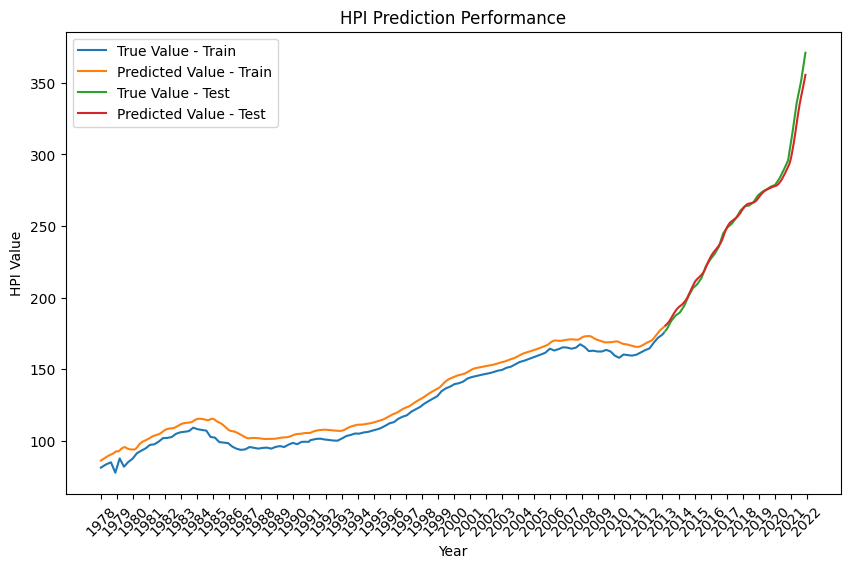

In [8]:
forecast_hpi('national_dallas_final.csv')

Reloading Tuner from my_dir/hpi_tuning/tuner0.json


4/4 [==============================] - 0s 4ms/step


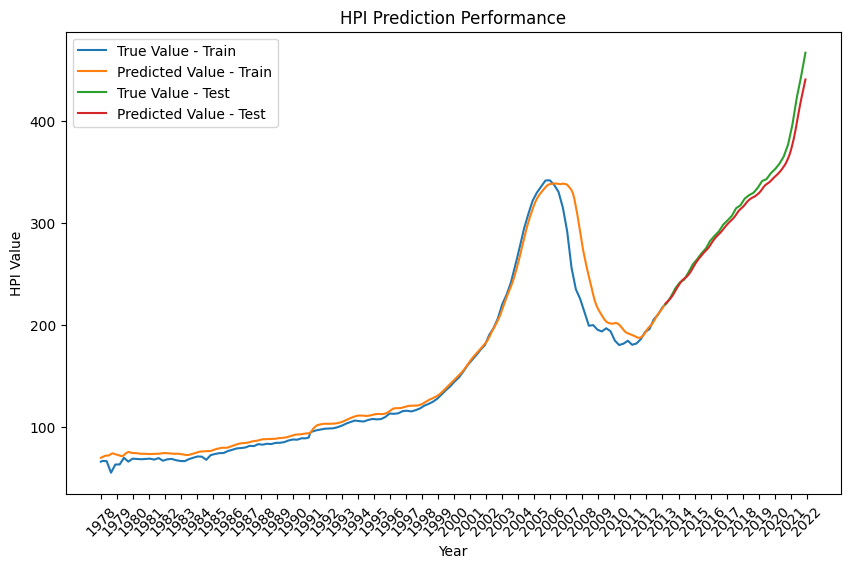

In [9]:
forecast_hpi("national_miami_final.csv")

Reloading Tuner from my_dir/hpi_tuning/tuner0.json


4/4 [==============================] - 0s 3ms/step


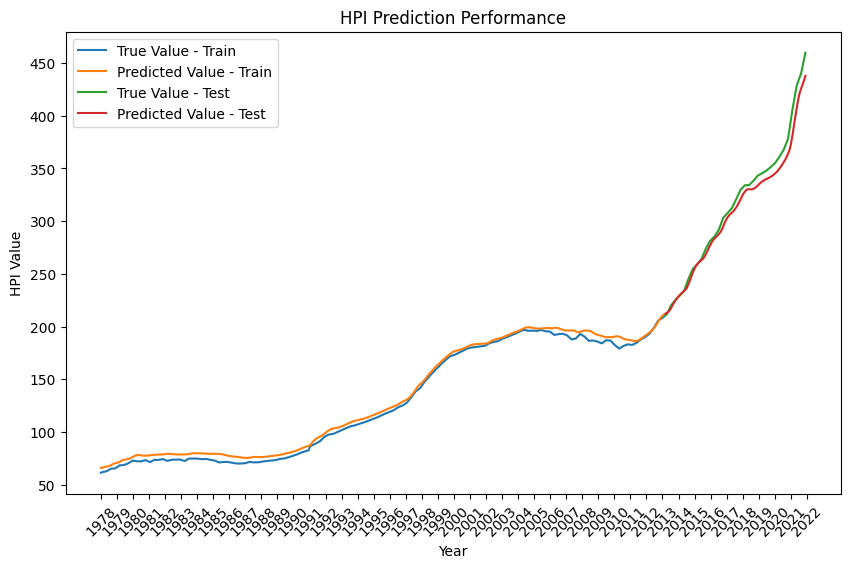

In [10]:
forecast_hpi("national_denver_final.csv")

Reloading Tuner from my_dir/hpi_tuning/tuner0.json


4/4 [==============================] - 0s 5ms/step


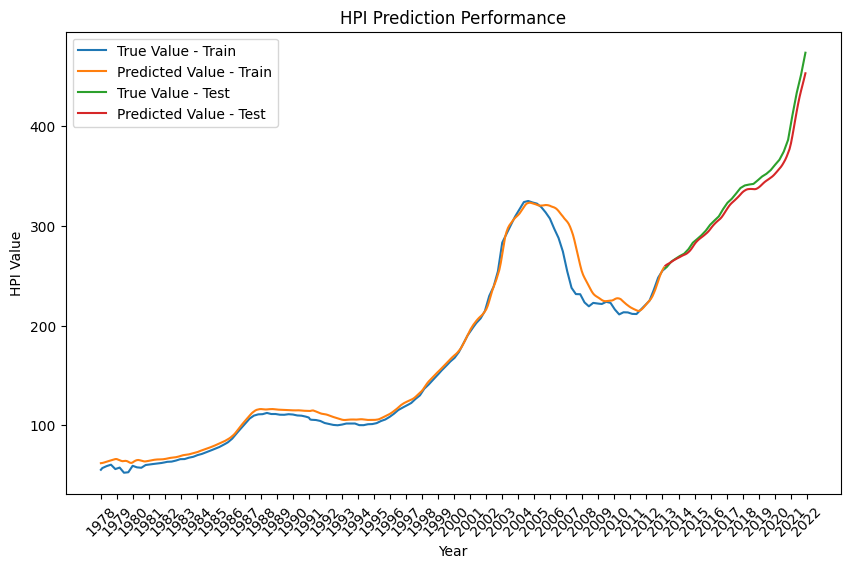

In [11]:
forecast_hpi("national_sd_final.csv")